In [21]:
# 8. Transfer Learning
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms, models
from torch import nn
import torch.nn.functional as F

import requests
from PIL import Image
import PIL.ImageOps

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [23]:
!ls ants_and_bees/train

ants bees


In [24]:
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                transforms.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

transform_train = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

training_dataset = datasets.ImageFolder('ants_and_bees/train', transform=transform)
validation_dataset = datasets.ImageFolder('ants_and_bees/val', transform=transform_train)
training_dataset

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=20, shuffle=False)
print('train length: ', len(training_loader), 'val length', len(validation_loader))


train length:  13 val length 8


In [25]:
print(len(training_dataset), len(validation_dataset))
training_loader.dataset == training_dataset


244 153


True

In [26]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.squeeze()
    image = image.transpose(1, 2, 0) # move channels: Color x w x h -> w x h x color
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image


In [27]:
classes = ['ant', 'bee']

In [28]:
# model = models.alexnet(pretrained=True)
model = models.vgg16(pretrained=True)
model

for param in model.features.parameters():
    param.requires_grad = False
    
import torch.nn as nn

n_inputs = model.classifier[6].in_features
model.to(device)

last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer

print(model)
print(model.classifier[6].out_features)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

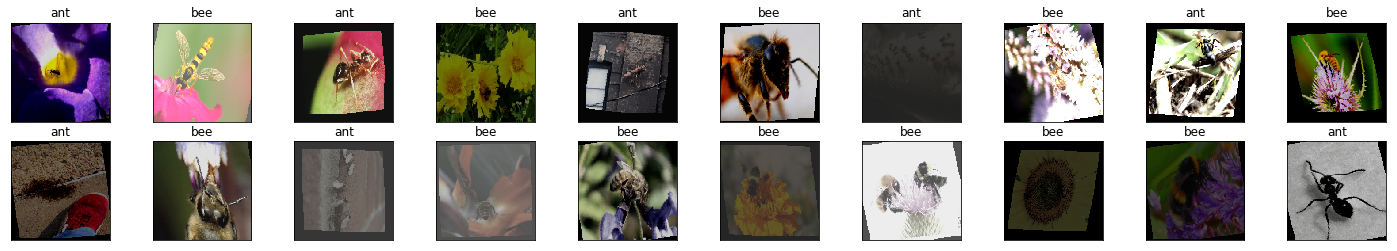

In [30]:
# for e in range(30):
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

In [31]:
epochs = 5
running_loss_history = []
running_corrects_history = []

val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0

    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # inputs = inputs.view(inputs.shape[0], -1) #1, 28, 28 -> flatten: 1, 784
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

    else:
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                # val_inputs = val_inputs.view(val_inputs.shape[0], -1)
                val_outputs = model(val_inputs)
                val_loss= criterion(val_outputs, val_labels)
                
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)

        epoch_loss = running_loss / len(training_loader.dataset)
        epoch_acc = running_corrects.float() / len(training_loader.dataset)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)

        val_epoch_loss = val_running_loss / len(validation_loader.dataset)
        val_epoch_acc = val_running_corrects.float() / len(validation_loader.dataset)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)

        print('epoch: ', e+1)
        print('training loss: {:.4f}, acc: {:.4f}'.format(epoch_loss, epoch_acc))
        print('validation loss: {:.4f}, validation acc: {:.4f}'.format(val_epoch_loss, val_epoch_acc))
    

epoch:  1
training loss: 0.0300, acc: 0.6885
validation loss: 0.0143, validation acc: 0.8889
epoch:  2
training loss: 0.0148, acc: 0.8934
validation loss: 0.0119, validation acc: 0.9150
epoch:  3
training loss: 0.0090, acc: 0.9303
validation loss: 0.0181, validation acc: 0.9020
epoch:  4
training loss: 0.0092, acc: 0.9344
validation loss: 0.0168, validation acc: 0.9150
epoch:  5
training loss: 0.0116, acc: 0.9057
validation loss: 0.0216, validation acc: 0.8954


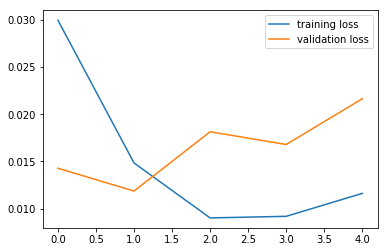

In [32]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

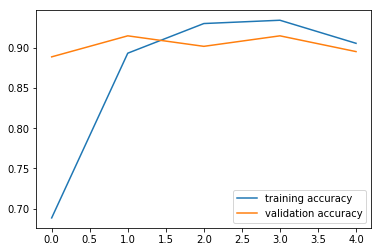

In [33]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

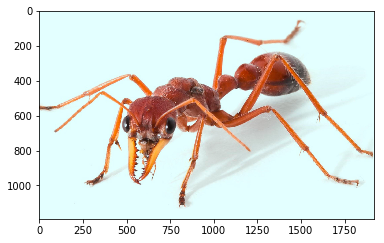

In [34]:
import requests
from PIL import Image

url = 'http://cdn.sci-news.com/images/enlarge5/image_6425e-Giant-Red-Bull-Ant.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

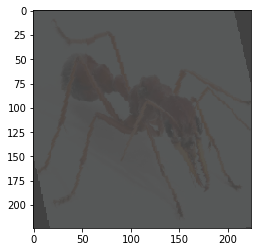

In [35]:
img = transform(img) 
plt.imshow(im_convert(img))

In [36]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

bee


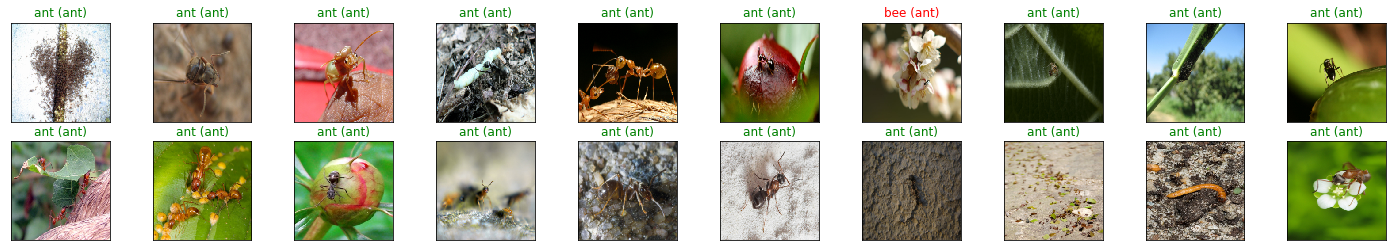

In [37]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))